# AV Behavior with friction implementation in rainy weather

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from scipy.stats import norm, binom, poisson
from dtaidistance import dtw
import json

## Testing Parameters

In [2]:
weather_param = [[20,0,0,5,0,0,0,10,0],
        [20,20,20,5,0,20,5,20,0],
        [40,40,40,5,0,40,10,30,0],
        [60,60,60,5,0,60,15,40,0],
        [80,80,80,5,0,80,20,50,0],
        [100,100,100,5,0,100,30,70,0]] 

# def calc_fric(weather_list):
#     return np.exp(-0.916*weather_list[5]/100) * (1-weather_list[5]/100)**3 * 0.6 + 0.4 - 0.1*weather_list[2]/100

# for i in range(len(weather_param)):
#     friction_ratio = calc_fric(weather_param[i])
#     weather_param[i] += [friction_ratio]

df = pd.DataFrame(weather_param, columns =["cloudiness","precipitation","precipitation_deposits","sun_altitude_angle","sun_azimuth_angle","wetness","fog_density","wind_intensity", "ice_thickness"],
) 
# df.index.name = 'Scenarios'
df

,cloudiness,precipitation,precipitation_deposits,sun_altitude_angle,sun_azimuth_angle,wetness,fog_density,wind_intensity,ice_thickness
0,20,0,0,5,0,0,0,10,0
1,20,20,20,5,0,20,5,20,0
2,40,40,40,5,0,40,10,30,0
3,60,60,60,5,0,60,15,40,0
4,80,80,80,5,0,80,20,50,0
5,100,100,100,5,0,100,30,70,0


### Without friction reduction

In [3]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [4]:
rel_path = "./Data/Ghost Cutin/Rain Original/Simulations Rain PC"
os.path.isdir(rel_path)

True

In [5]:
subfolders = os.listdir(path=rel_path)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin']

In [6]:
head = subfolders.pop(1)
subfolders.append(head)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

In [7]:
txt_lists_fric = [[] for i in range(6)]

for i in range(len(txt_lists_fric)):
    for root, dirs, files in os.walk(os.path.join(rel_path, subfolders[i])):
        for file in files:
            if file.endswith(".txt"):
                 with open(os.path.join(root, file), encoding = 'utf-8') as f:
                    read_string = f.read()
                    json_object = json.loads(read_string)
                    txt_lists_fric[i].append(json_object)

In [8]:
txt_lists_fric[2][50]
# txt_lists_fric[0]

{'_checkpoint': {'global_record': {},
  'progress': [0, 1],
  'records': [{'index': 0,
    'infractions': {'collisions_layout': [],
     'collisions_pedestrian': [],
     'collisions_vehicle': [],
     'outside_route_lanes': [],
     'red_light': [],
     'route_dev': [],
     'route_timeout': [],
     'stop_infraction': [],
     'vehicle_blocked': []},
    'meta': {'duration_game': 19.125000284984708,
     'duration_system': 30.239914417266846,
     'route_length': 131.56012567009267},
    'route_id': 'RouteScenario_0',
    'scores': {'score_composed': 100.0,
     'score_penalty': 1.0,
     'score_route': 100.0},
    'status': 'Completed'}]},
 'eligible': False,
 'entry_status': 'Started',
 'labels': [],
 'sensors': ['carla_camera',
  'carla_camera',
  'carla_camera',
  'carla_imu',
  'carla_gnss',
  'carla_speedometer'],
 'values': []}

In [9]:
avg_complete = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        if txt['_checkpoint']['records'][0]['status'] == 'Completed':
            count += 1
    avg_complete[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average complete ratio':avg_complete}) 
# df.index.name = 'Scenarios'

df

,Scenarios,Average complete ratio
0,route_highway_epoch24_clear-sunset_fi_ghost_cutin,1.0
1,route_highway_epoch24_rain-sunset-20_fi_ghost_cutin,1.0
2,route_highway_epoch24_rain-sunset-40_fi_ghost_cutin,1.0
3,route_highway_epoch24_rain-sunset-60_fi_ghost_cutin,1.0
4,route_highway_epoch24_rain-sunset-80_fi_ghost_cutin,1.0
5,route_highway_epoch24_rain-sunset-100_fi_ghost_cutin,1.0


In [10]:
count = 0

avg_score = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        count += txt['_checkpoint']['records'][0]['scores']['score_route'] 
    avg_score[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average score route':avg_complete}) 
df

,Scenarios,Average score route
0,route_highway_epoch24_clear-sunset_fi_ghost_cutin,1.0
1,route_highway_epoch24_rain-sunset-20_fi_ghost_cutin,1.0
2,route_highway_epoch24_rain-sunset-40_fi_ghost_cutin,1.0
3,route_highway_epoch24_rain-sunset-60_fi_ghost_cutin,1.0
4,route_highway_epoch24_rain-sunset-80_fi_ghost_cutin,1.0
5,route_highway_epoch24_rain-sunset-100_fi_ghost_cutin,1.0


#### Setting up into list of DataFrames

In [11]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [12]:
os.path.isdir("./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin\\route_highway_epoch24_clear-sunset_fi_ghost_cutin_0\\")

True

In [13]:
df_array_orig = np.empty((6,100), dtype=object)

for i in range(len(df_array_orig)):
    for j in range((len(df_array_orig[i]))):
        df_array_orig[i][j] = pd.DataFrame()

In [14]:
rel_path = "./Data/Ghost Cutin/Rain Original/Simulations Rain PC/"

for i in range(len(txt_lists_fric)):
    dir_path = os.path.join(rel_path, subfolders[i])
    print(dir_path)
    
    # list to store files
    res = []

    # Iterate directory
    run_index = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if not os.path.isfile(os.path.join(dir_path, path)):
            df = pd.DataFrame()
            for file in os.listdir(os.path.join(dir_path, path)):
                file_path = os.path.join(dir_path, os.path.join(path, file))
    #             print("file_path", file_path)
                if "_ctl.csv" in file_path:
                    df = pd.read_csv(file_path)
                elif "_cvip.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)
                elif "_traj.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)

            df_array_orig[i][run_index] = df
            run_index += 1

./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-20_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-40_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-60_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-80_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-100_fi_ghost_cutin


In [15]:
df_array_orig[5][99]

,ts,agent_id,throttle,steer,brake,ts,agent_id,cvip,cvip_x,cvip_y,cvip_z,ts,agent_id,x,y,z,v
0,2489301,0,0.900000,-0.012481,0.0,2489301,0,500.491189,198.767441,-95.832657,-499.819366,2489301,0,192.362411,-86.262680,0.539326,0.000000
1,2489302,0,0.900000,-0.001971,0.0,2489302,0,5.595580,195.567444,-90.832657,0.100000,2489302,0,192.362411,-86.262680,0.491906,0.000000
2,2489303,0,0.900000,-0.002299,0.0,2489303,0,5.592365,195.567444,-90.832657,0.095407,2489303,0,192.362411,-86.262680,0.438374,0.000000
3,2489304,0,0.900000,0.000192,0.0,2489304,0,5.589578,195.567444,-90.832657,0.084691,2489304,0,192.362411,-86.262680,0.378732,0.000000
4,2489305,0,0.900000,-0.000547,0.0,2489305,0,5.587154,195.567444,-90.832657,0.069311,2489305,0,192.362411,-86.262680,0.312981,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,2490059,0,0.419231,-0.002111,0.0,2490059,0,56.819623,192.527084,99.899643,0.001829,2490059,0,193.190323,43.083900,0.033927,9.010618
759,2490060,0,0.217665,-0.001856,0.0,2490060,0,56.927476,192.519760,100.232491,0.001824,2490060,0,193.187576,43.308941,0.033934,8.999552
760,2490061,0,0.244805,-0.002024,0.0,2490061,0,57.035954,192.511963,100.565674,0.001821,2490061,0,193.184875,43.533699,0.033941,8.988723
761,2490062,0,0.444254,-0.001082,0.0,2490062,0,57.145036,192.503708,100.899216,0.001817,2490062,0,193.182205,43.758217,0.033948,8.979064


In [16]:
df_array_orig[2][1]['x']

0      192.362411
1      192.362411
2      192.362411
3      192.362411
4      192.362411
          ...    
761    193.198181
762    193.195145
763    193.192139
764    193.189209
765    193.186340
Name: x, Length: 766, dtype: float64

## Comparison

In [17]:
attribute_order = ["x", "y", "v", "cvip", "steer", "brake", "throttle"]

all_medians = np.empty((len(txt_lists_fric), len(attribute_order)), dtype=object)
# [[[], []] * len(attribute_order)  for i in range(len(txt_lists_fric))]

all_medians

array([[None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None]], dtype=object)

In [20]:
full_legend = subfolders.copy()

### x,y traces

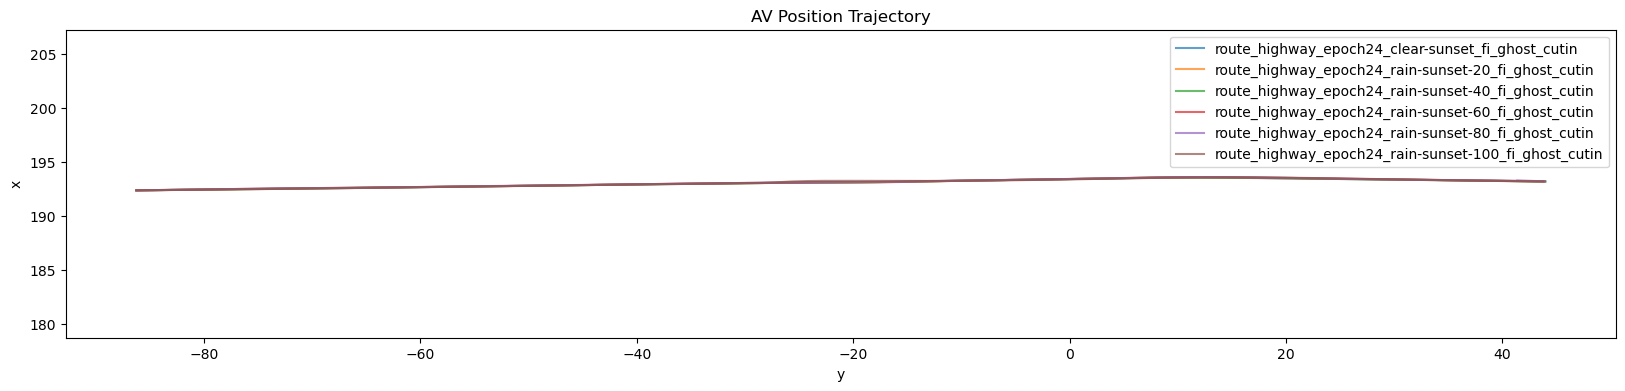

In [34]:
plt.figure(figsize=(20,4))

for weather in range(len(txt_lists_fric)):
    df_orig_x = pd.DataFrame()
    df_orig_y = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['x'].dtypes == 'object' or df_array_orig[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['x'].isnull().values.any() and not df_array_orig[weather][i]['y'].isnull().values.any():
                df_orig_x["Run"+str(i)] = df_array_orig[weather][i]['x']
                df_orig_y["Run"+str(i)] = df_array_orig[weather][i]['y']

    median_orig_x = df_orig_x.median(axis=1)
    median_orig_y = df_orig_y.median(axis=1)

    plt.plot(median_orig_y, median_orig_x, alpha=0.7)


plt.axis('equal')
plt.xlabel("y")
plt.ylabel("x")
plt.title("AV Position Trajectory")
plt.legend(full_legend)
plt.show()

### v

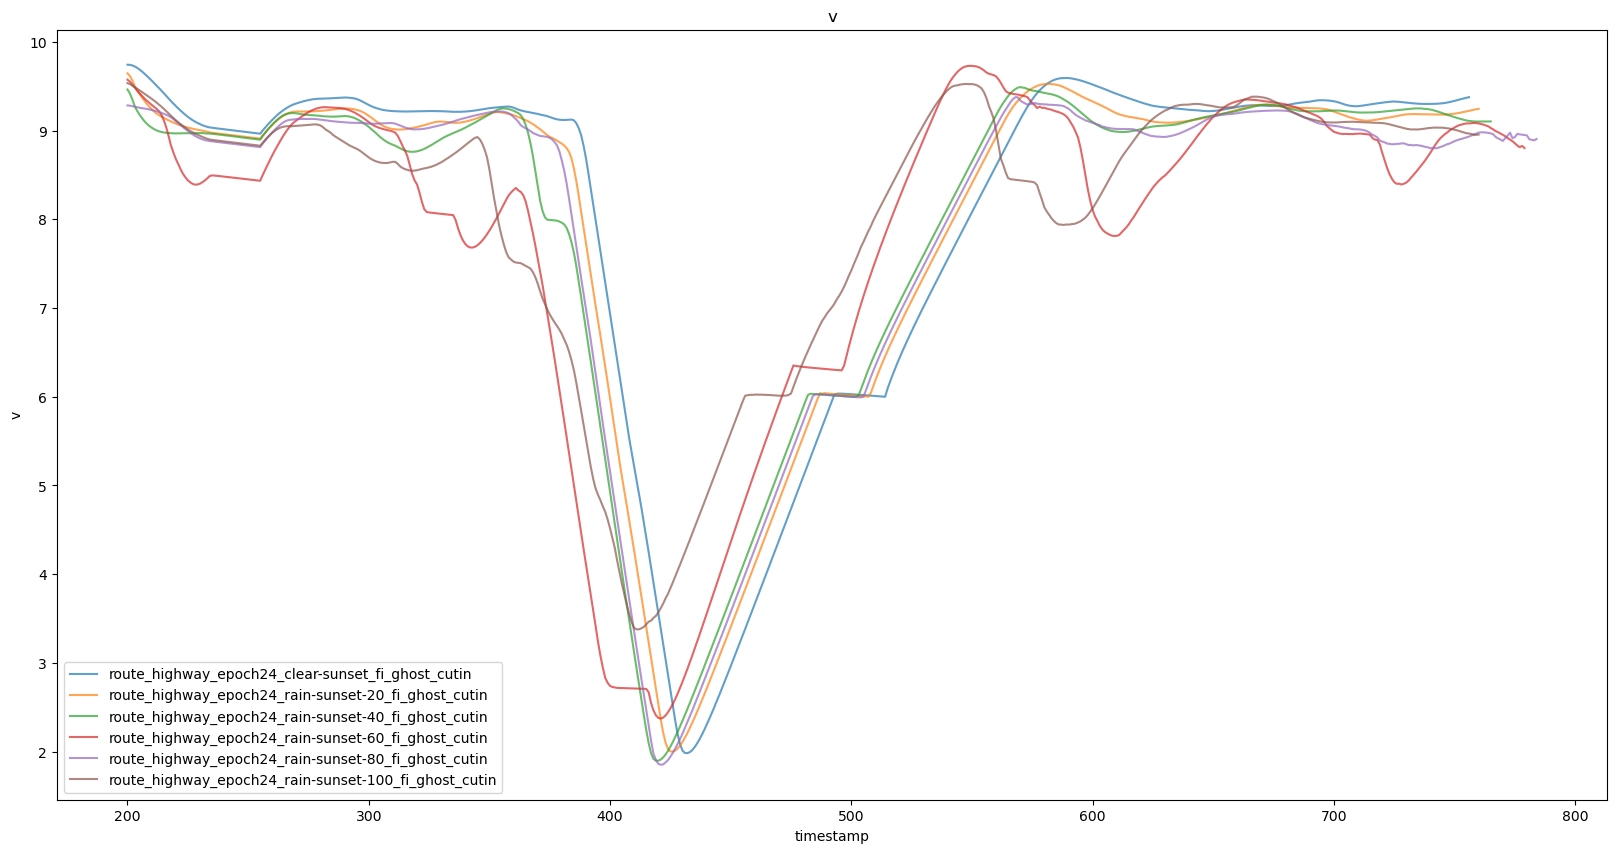

In [22]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
    df_orig_v = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['v'].dtypes == 'v'):
            print(i)
        else:
            if not df_array_orig[weather][i]['v'].isnull().values.any():
                df_orig_v["Run"+str(i)] = df_array_orig[weather][i]['v']

    median_orig_v = df_orig_v.median(axis=1)


    plt.plot(median_orig_v[200:], alpha=0.7)

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("v")
plt.title("v")
plt.legend(full_legend)
plt.show()

### cvip

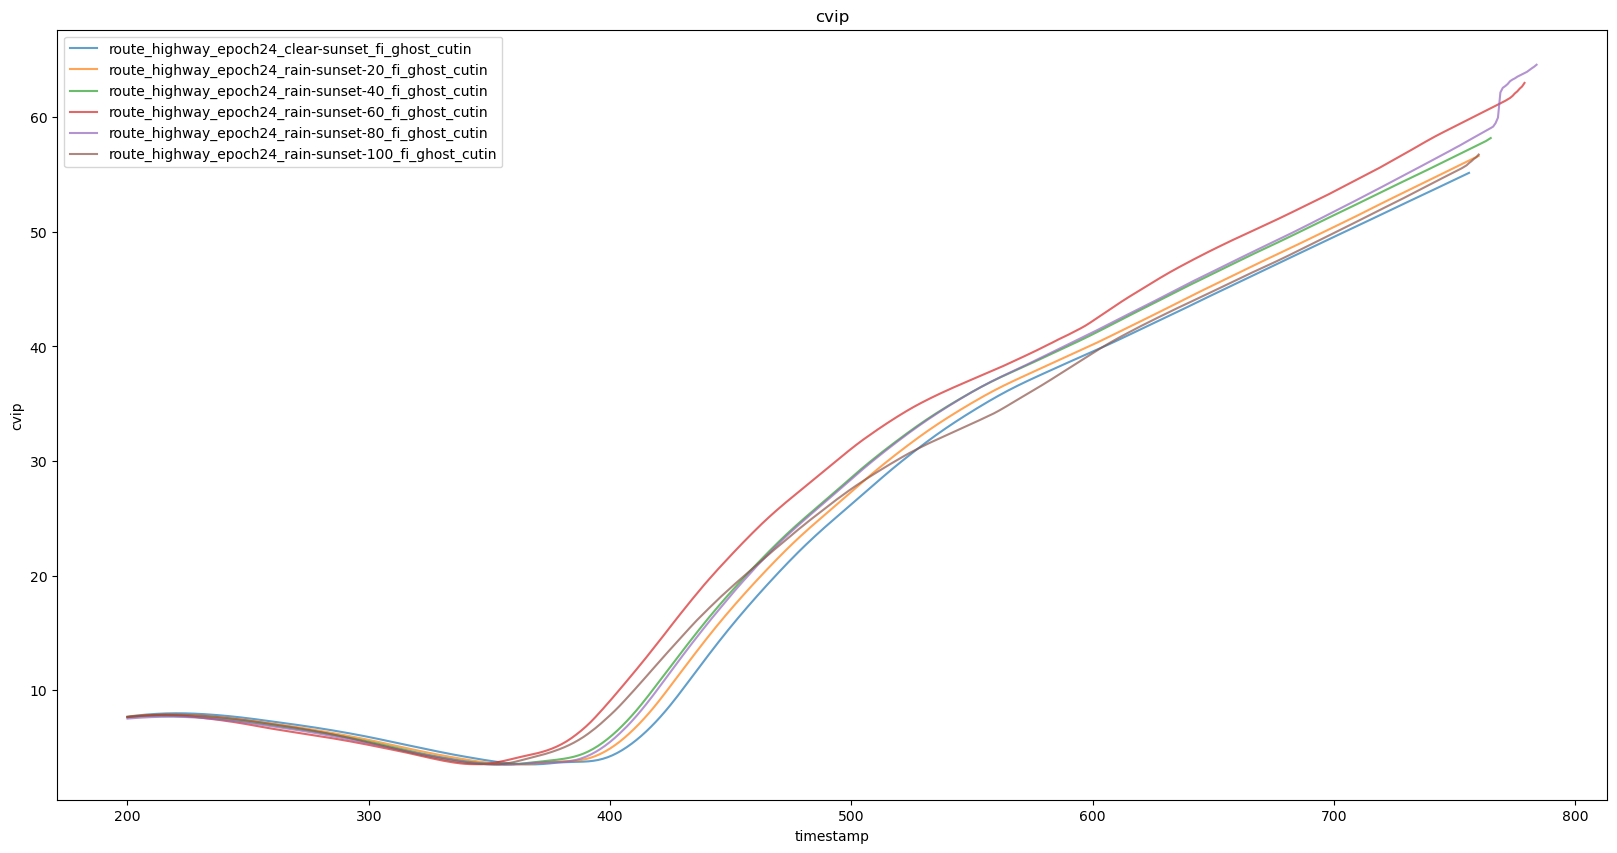

In [29]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
    df_orig_cvip = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['cvip'].isnull().values.any():
                df_orig_cvip["Run"+str(i)] = df_array_orig[weather][i]['cvip']

    median_orig_cvip = df_orig_cvip.median(axis=1)


    plt.plot(median_orig_cvip[200:], alpha=0.7)

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("cvip")
plt.title("cvip")
plt.legend(full_legend)
plt.show()

### steer

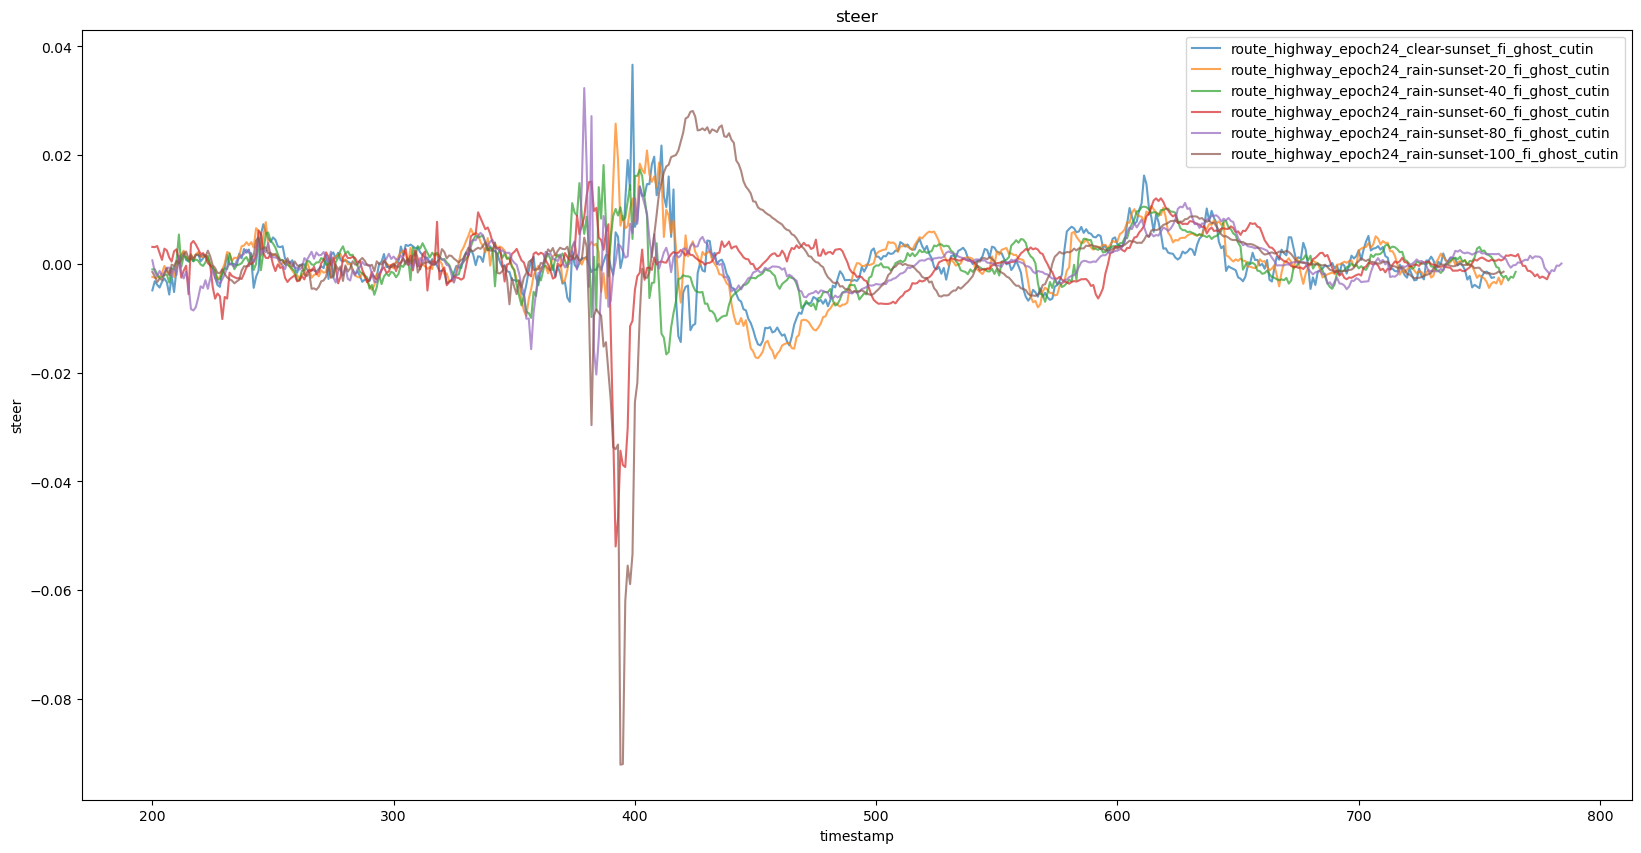

In [30]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
    df_orig_steer = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['steer'].dtypes == 'steer'):
            print(i)
        else:
            if not df_array_orig[weather][i]['steer'].isnull().values.any():
                df_orig_steer["Run"+str(i)] = df_array_orig[weather][i]['steer']

    median_orig_steer = df_orig_steer.median(axis=1)


    plt.plot(median_orig_steer[200:], alpha=0.7)

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("steer")
plt.title("steer")
plt.legend(full_legend)
plt.show()

### brake

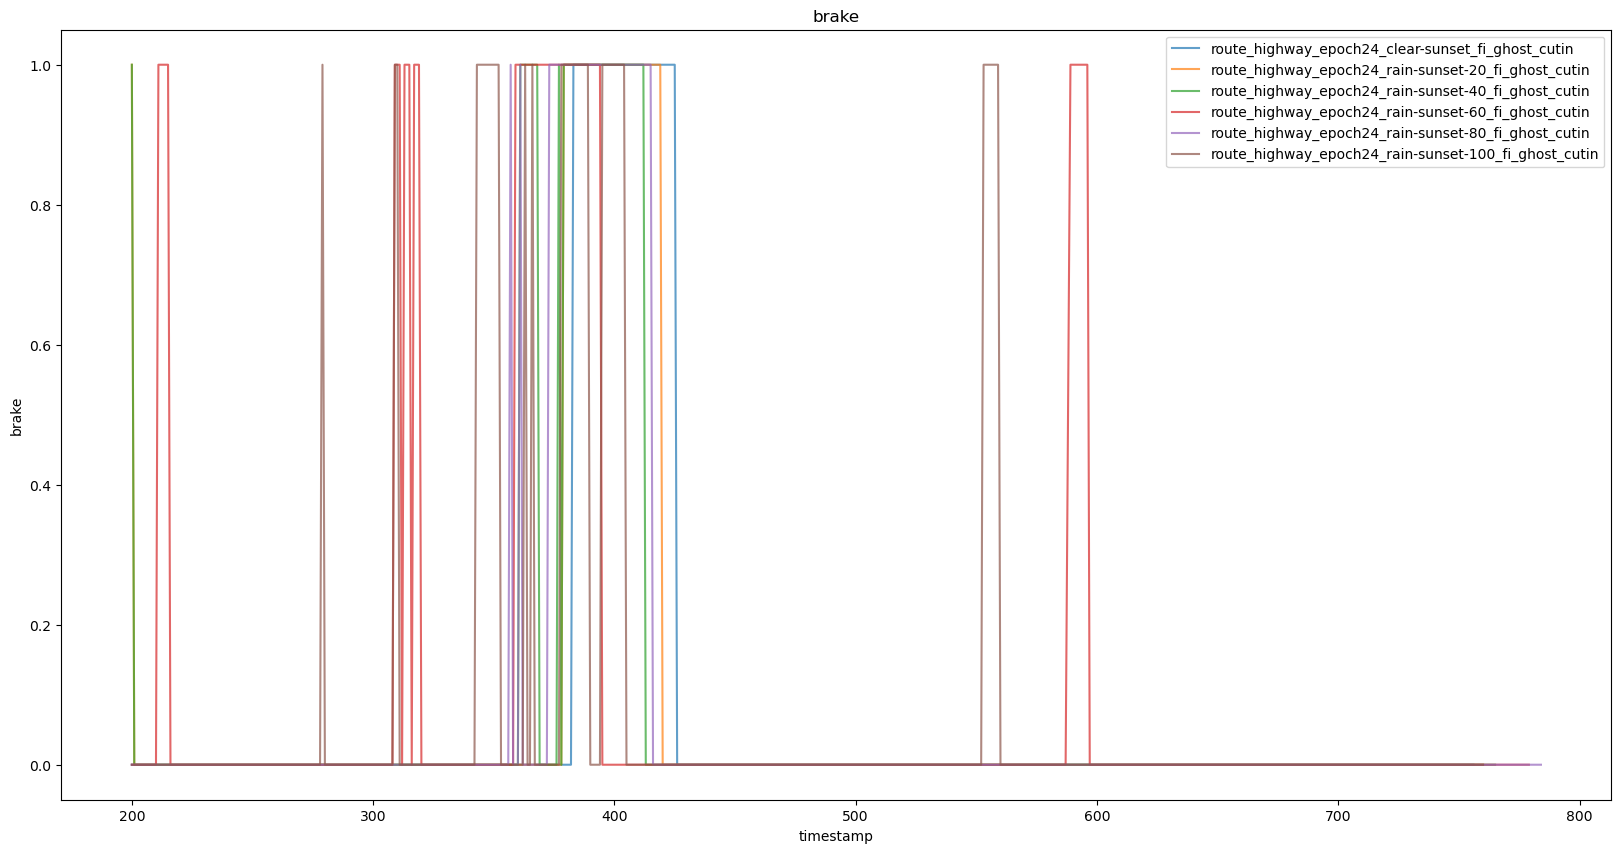

In [31]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
    df_orig_brake = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['brake'].dtypes == 'brake'):
            print(i)
        else:
            if not df_array_orig[weather][i]['brake'].isnull().values.any():
                df_orig_brake["Run"+str(i)] = df_array_orig[weather][i]['brake']

    median_orig_brake = df_orig_brake.median(axis=1)


    plt.plot(median_orig_brake[200:], alpha=0.7)

plt.xlabel("timestamp")
plt.ylabel("brake")
plt.title("brake")
plt.legend(full_legend)
plt.show()

In [ ]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_throttle = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['throttle'].isnull().values.any():
                df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

    median_orig_throttle = df_orig_throttle.median(axis=1)

    plt.plot(median_orig_throttle, alpha=0.7)


    df_fric_throttle = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['throttle'].isnull().values.any():
                df_fric_throttle["Run"+str(i)] = df_array_fric[weather][i]['throttle']

    median_fric_throttle = df_fric_throttle.median(axis=1)
    
    all_medians[weather][6][0] = median_orig_throttle
    all_medians[weather][6][1] = median_fric_throttle
    
    plt.plot(median_fric_throttle, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("throttle")
    plt.ylabel("Velocity")
    plt.title(subfolders[weather] + " (throttle)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("throttle")
    plt.ylabel("Density")
    median_orig_throttle.plot.density(alpha=0.7)
    median_fric_throttle.plot.density(style='--')
    plt.title(subfolders[weather] + " (throttle)")
    plt.legend(friction_legend)
    plt.show()
    

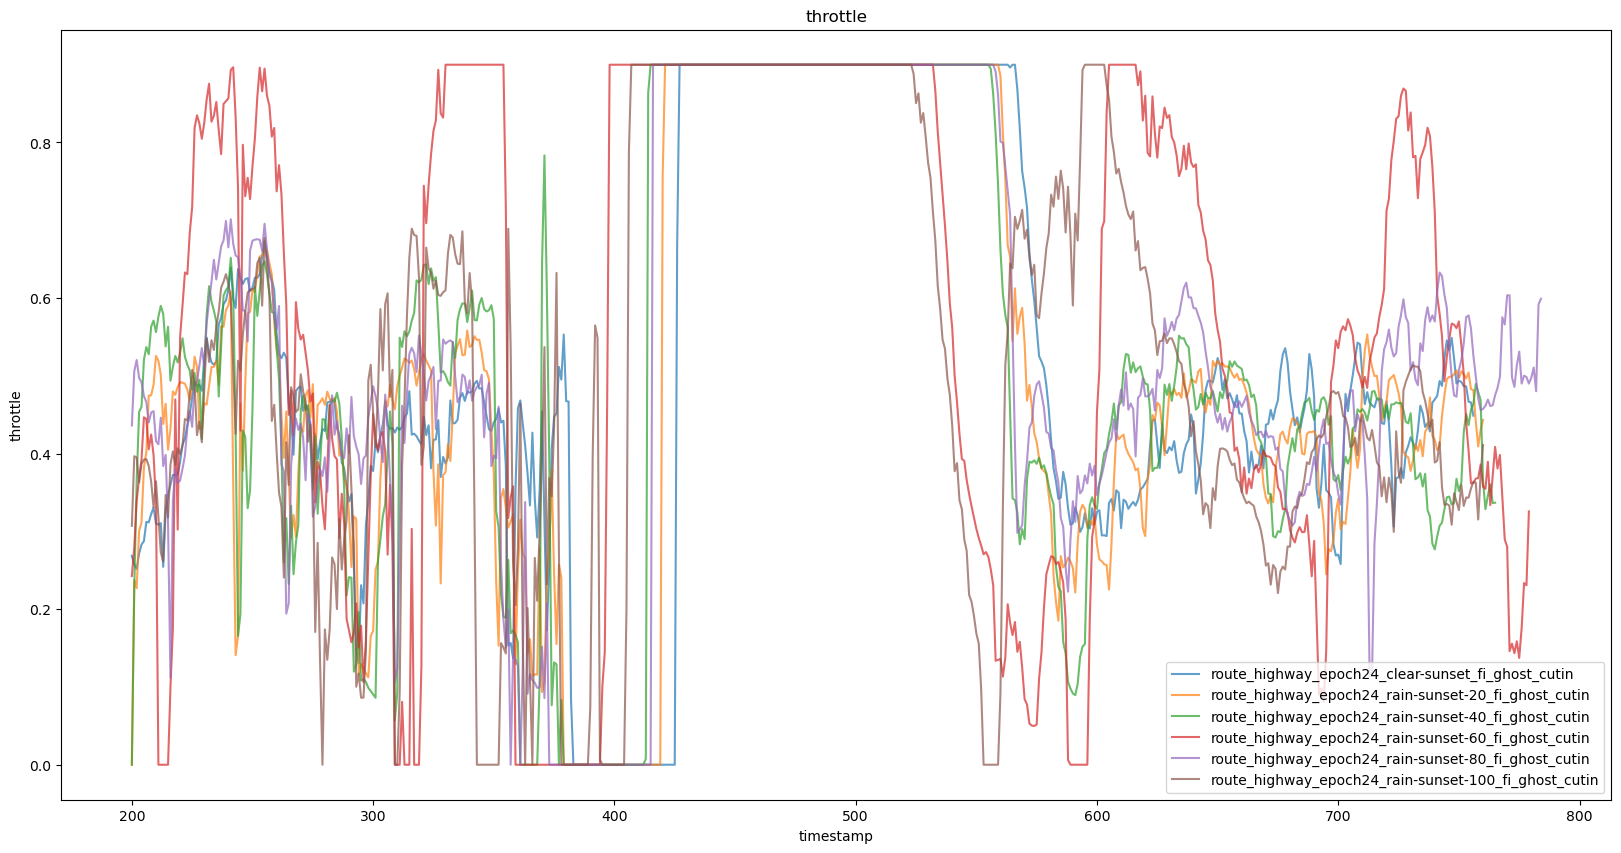

In [32]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
    df_orig_throttle = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['throttle'].dtypes == 'throttle'):
            print(i)
        else:
            if not df_array_orig[weather][i]['throttle'].isnull().values.any():
                df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

    median_orig_throttle = df_orig_throttle.median(axis=1)


    plt.plot(median_orig_throttle[200:], alpha=0.7)

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("throttle")
plt.title("throttle")
plt.legend(full_legend)
plt.show()

## Dynamic time warping (DTW) for cvip
### measuring similarity between two temporal sequences

In [33]:
all_dtw = [[0] * len(attribute_order)  for i in range(len(txt_lists_fric))]

for i in range(1, len(txt_lists_fric)):
    for j in range(len(attribute_order)):
        all_dtw[i][j] = dtw.distance(all_medians[0][j], all_medians[i][j])

TypeError: object of type 'NoneType' has no len()

In [ ]:
df = pd.DataFrame(all_dtw, columns = attribute_order, dtype = float)
df.index = subfolders
df

## KS Test for cvip

In [ ]:
import scipy as sp

In [ ]:
all_ks = np.empty((len(txt_lists_fric), len(attribute_order), 2))
# [[0] * len(attribute_order)  for i in range(len(txt_lists_fric)-1)]
for i in range(len(txt_lists_fric)-1):
    for j in range(len(attribute_order)):
        ks_test = sp.stats.ks_2samp(all_medians[i][j][0], all_medians[i][j][1])
        all_ks[i][j][0] = ks_test.pvalue
        all_ks[i][j][1] = ks_test.statistic

In [ ]:
df = pd.DataFrame(all_ks[:,:,0], columns = attribute_order, dtype = float)
df.index = subfolders
df

In [ ]:
df = pd.DataFrame(all_ks[:,:,1], columns = attribute_order, dtype = float)
df.index = subfolders
df

You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.
**pvalue=4.2177381979173086e-06**